### Import required libraries

In [1]:

import matplotlib.pyplot as plt 
import tensorflow as tf 
import pandas as pd 
import numpy as np 
  
import warnings 
warnings.filterwarnings('ignore') 
  
from tensorflow import keras 
from keras import layers 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense 
from tensorflow.keras.layers import Conv2D, MaxPooling2D 
from tensorflow.keras.utils import image_dataset_from_directory 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img 
from tensorflow.keras.preprocessing import image_dataset_from_directory 
  
import os 
import matplotlib.image as mpimg

import zipfile


2024-01-31 08:41:19.960583: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-31 08:41:20.958511: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-31 08:41:20.961804: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-31 08:41:28.276062: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Extract the dataset which is in zip file

In [61]:

from zipfile import ZipFile 
  
data_path = 'train.zip'
  
with ZipFile(data_path, 'r') as zip: 
    zip.extractall() 
    print('The data set has been extracted.') 

# Define the source and destination folders
source_folder = "train"  # Your original folder with all images
cat_folder = os.path.join( "/dataset/cats")
dog_folder = os.path.join( "/dataset/dogs")

# Create the destination folders if they don't exist
os.makedirs(cat_folder, exist_ok=True)
os.makedirs(dog_folder, exist_ok=True)

# Loop through each image in the source folder
for filename in os.listdir(source_folder):
    # Extract the label (cat or dog) from the filename
    label = filename.split(".")[0].split("_")[0]

    # Build the destination path based on the label
    dest_folder = cat_folder if label == "cat" else dog_folder

    # Move the image to the corresponding folder
    os.rename(os.path.join(source_folder, filename), os.path.join(dest_folder, filename))

print("Images successfully separated into 'dataset/cats' and 'dataset/dogs' folders!")


Images successfully separated into 'dataset/cats' and 'dataset/dogs' folders!


### Split the dataset into train and validation

In [62]:
import os
from sklearn.model_selection import train_test_split

# Specify the path to the main train folder
train_dir = "./dataset/train/"

# Iterate through the cats and dogs folders within train_dir
for class_folder in ['cats', 'dogs']:
    class_path = os.path.join(train_dir, class_folder)
    images = [os.path.join(class_path, filename) for filename in os.listdir(class_path)]

    # Split the images within each class folder into training and validation sets
    train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)

    # You can now use train_images and val_images for model training and validation


In [ ]:
import splitfolders

# Specify the path to the main train folder
input_dir = './dataset/'
output_dir = './dataset/split_output'

# Split each class folder within train_dir into training and validation sets
splitfolders.ratio(input_dir, output=output_dir, seed=1337, ratio=(0.8, 0.2), group_prefix=None)

# The split data will be organized into subfolders within output_dir


In [2]:

data_dir = 'dataset/split_output/'

train_dir = data_dir + 'train/'
test_dir = data_dir + 'val/'

In [3]:
cat_samples_dir_train = train_dir + 'cats/'
dog_samples_dir_train = train_dir + 'dogs/'



### Visulize

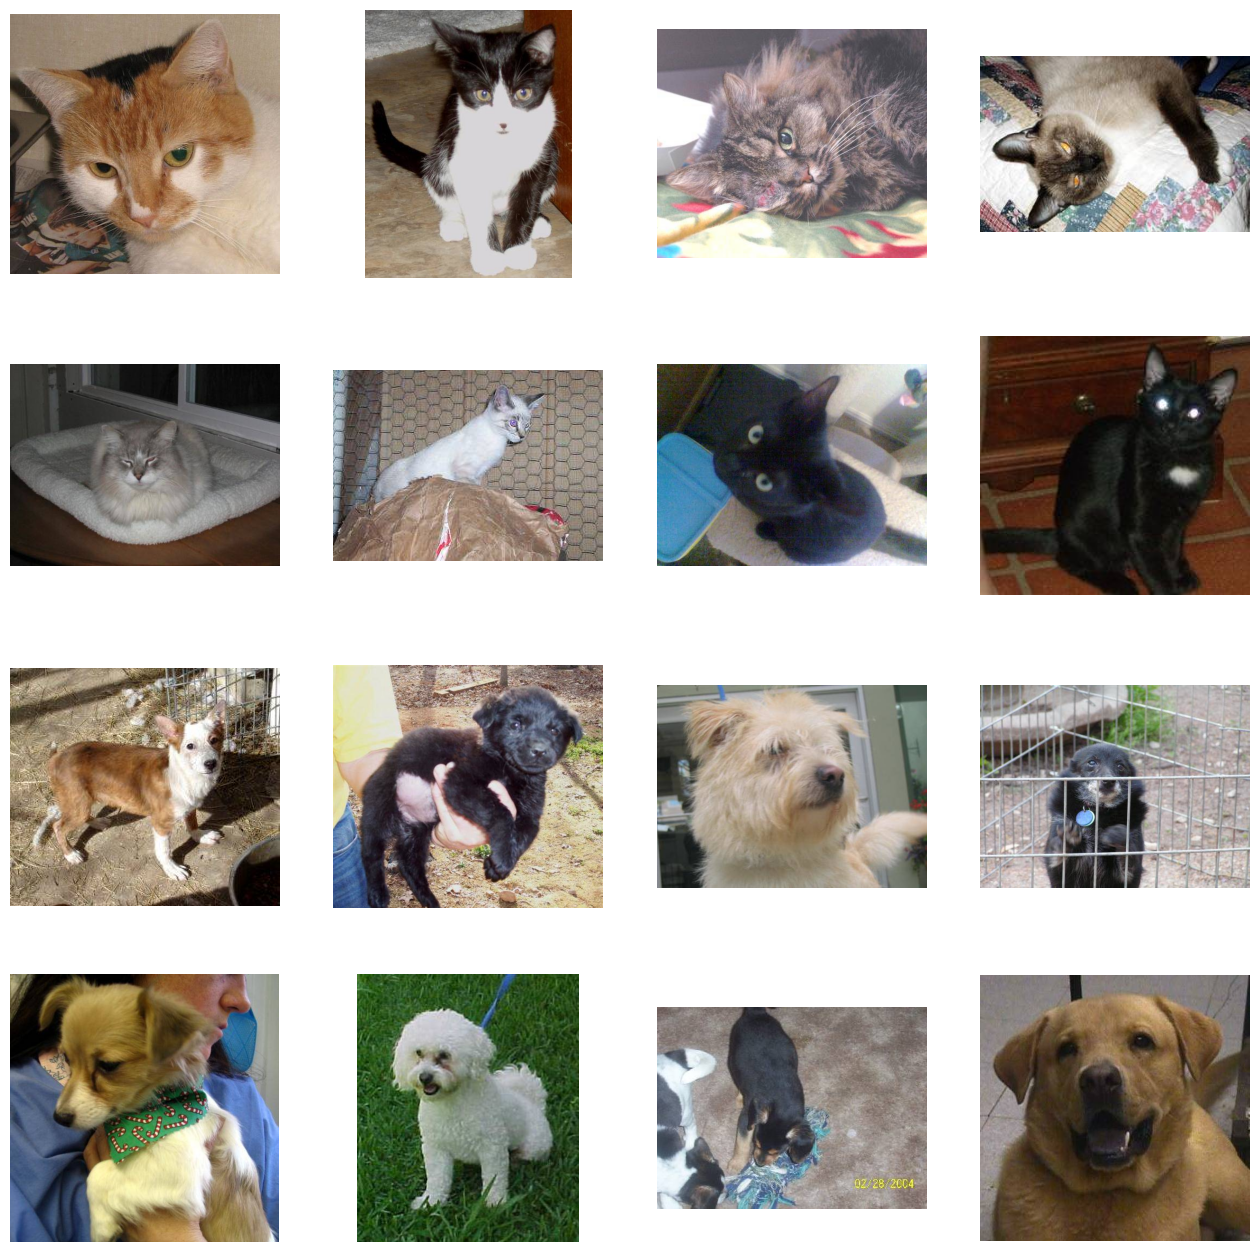

In [63]:

fig = plt.gcf() 
fig.set_size_inches(16, 16) 
  
cat_dir = os.path.join('dataset/split_output/train/cats') 
dog_dir = os.path.join('dataset/split_output/train/dogs') 
cat_names = os.listdir(cat_dir) 
dog_names = os.listdir(dog_dir) 
  
pic_index = 210
  
cat_images = [os.path.join(cat_dir, fname) 
              for fname in cat_names[pic_index-8:pic_index]] 
dog_images = [os.path.join(dog_dir, fname) 
              for fname in dog_names[pic_index-8:pic_index]] 
  
for i, img_path in enumerate(cat_images + dog_images): 
    sp = plt.subplot(4, 4, i+1) 
    sp.axis('Off') 
  
    img = mpimg.imread(img_path) 
    plt.imshow(img) 
  
plt.show() 

### Data Preparation For training

In [4]:
import glob
from pathlib import Path

In [5]:
def make_csv_with_image_labels(CATS_PATH, DOGS_PATH):
    '''
    Function for making a dataframe that contains images path as well as their labels.
    Parameters:-
     - CATS_PATH - Path for Cats  Images
     - DOGS_PATH - Path for Dogs Images
    Output:-
    It simply returns dataframe
    '''
    cat_images = Path(CATS_PATH).glob('*.jpg')
    dog_images = Path(DOGS_PATH).glob('*.jpg')

    df = []
    for i in cat_images:
        df.append((i, 0))
    for j in dog_images:
        df.append((j, 1))

    df = pd.DataFrame(df, columns=["image_path", "label"], index = None)
    df = df.sample(frac = 1).reset_index(drop=True)

    return df

train_csv = make_csv_with_image_labels(cat_samples_dir_train,dog_samples_dir_train)
train_csv.head()

,image_path,label
0,dataset/split_output/train/cats/cat.4689.jpg,0
1,dataset/split_output/train/dogs/dog.12297.jpg,1
2,dataset/split_output/train/dogs/dog.10070.jpg,1
3,dataset/split_output/train/cats/cat.9188.jpg,0
4,dataset/split_output/train/cats/cat.3559.jpg,0


In [6]:
train_csv.tail()

,image_path,label
19995,dataset/split_output/train/dogs/dog.11448.jpg,1
19996,dataset/split_output/train/cats/cat.2757.jpg,0
19997,dataset/split_output/train/cats/cat.9724.jpg,0
19998,dataset/split_output/train/cats/cat.11640.jpg,0
19999,dataset/split_output/train/cats/cat.10036.jpg,0


In [7]:
# len(train_csv)


Total No. Of CAT Samples :-  10000
Total No. Of DOG Samples :-  10000


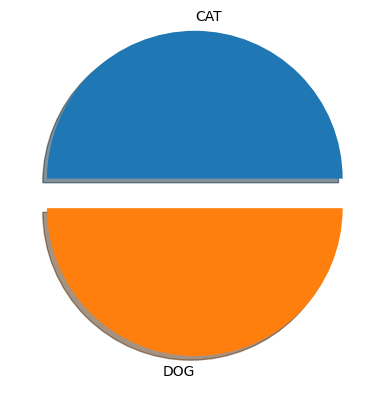

In [8]:

len_cat = len(train_csv["label"][train_csv.label == 0])
len_dog = len(train_csv["label"][train_csv.label == 1])

arr = np.array([len_cat , len_dog])
labels = ['CAT', 'DOG']
print("Total No. Of CAT Samples :- ", len_cat)
print("Total No. Of DOG Samples :- ", len_dog)

plt.pie(arr, labels=labels, explode = [0.2,0.0] , shadow=True)
plt.show()

Preparing the training and testing data

In [9]:

def get_train_generator(train_dir, batch_size=32, target_size=(224, 224)):
    '''
    Function for preparing training data
    '''
    train_datagen = ImageDataGenerator(#rescale = 1./255., # normalizing the image
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

    train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = batch_size,
                                                    color_mode='rgb',
                                                    class_mode = 'binary',
                                                    target_size = target_size)
    return train_generator


train_generator = get_train_generator(train_dir)

Found 20000 images belonging to 2 classes.


In [10]:
def get_testgenerator(test_dir,batch_size=64, target_size=(224,224)):
    '''
    Function for preparing testing data
    '''
    test_datagen = ImageDataGenerator( #rescale = 1.0/255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True )
    test_generator  =  test_datagen.flow_from_directory(test_dir,
                                                          batch_size  = batch_size,
                                                          color_mode='rgb',
                                                          class_mode  = 'binary',
                                                          target_size = target_size)
    return test_generator

test_generator = get_testgenerator(test_dir)

Found 5000 images belonging to 2 classes.


### Implement early stopping to stop overfitting

In [11]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,         # Stop training after 5 epochs with no improvement
    restore_best_weights=True  # Restore weights of the best model
)


### Model Architecture

In [12]:

# building the model
model = tf.keras.Sequential([
    layers.Conv2D(64, (3,3), strides=(2,2),padding='same',input_shape= (224,224,3),activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    layers.MaxPool2D(2,2),
    layers.Conv2D(128, (3,3), strides=(2,2),padding='same',activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    layers.MaxPool2D(2,2),
    layers.Conv2D(256, (3,3), strides=(2,2),padding='same',activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    layers.MaxPool2D(2,2),
    layers.Flatten(),
    layers.Dense(158, activation ='relu'),
    layers.Dense(256, activation = 'relu'),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(1, activation = 'sigmoid'),
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 64)      1792      
                                                                 
 dropout (Dropout)           (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 dropout_1 (Dropout)         (None, 28, 28, 128)       0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 128)      0         
 2D)                                                    

### Model Training

In [13]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['acc'])

import warnings
warnings.filterwarnings('ignore')
print('warnings ignored')

history = model.fit_generator(train_generator,
                              epochs=15,
                              verbose=1,
                              validation_data=test_generator,
                              callbacks=[early_stopping])

warnings ignored


Epoch 1/15


2024-01-31 08:41:52.984984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-01-31 08:42:00.697049: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.
2024-01-31 08:42:01.090262: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.
2024-01-31 08:42:01.090354: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.
2024-01-31 08:42:01.541016: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25690112 exceeds 10% of free system memory.
2024-01-31 08:42:01.773169: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25690112 exceeds 10%

625/625 [==============================] - ETA: 0s - loss: 1.8278 - acc: 0.5318

2024-01-31 09:04:00.853897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


625/625 [==============================] - 1510s 2s/step - loss: 1.8278 - acc: 0.5318 - val_loss: 0.6720 - val_acc: 0.5974
Epoch 2/15
625/625 [==============================] - 1902s 3s/step - loss: 0.6758 - acc: 0.5938 - val_loss: 0.6592 - val_acc: 0.6380
Epoch 3/15
625/625 [==============================] - 1650s 3s/step - loss: 0.6627 - acc: 0.6163 - val_loss: 0.6593 - val_acc: 0.5846
Epoch 4/15
625/625 [==============================] - 1549s 2s/step - loss: 0.6390 - acc: 0.6439 - val_loss: 0.6552 - val_acc: 0.6138
Epoch 5/15
625/625 [==============================] - 1282s 2s/step - loss: 0.6142 - acc: 0.6670 - val_loss: 0.6052 - val_acc: 0.6826
Epoch 6/15
625/625 [==============================] - 1247s 2s/step - loss: 0.5960 - acc: 0.6913 - val_loss: 0.5455 - val_acc: 0.7238
Epoch 7/15
625/625 [==============================] - 1238s 2s/step - loss: 0.5871 - acc: 0.6999 - val_loss: 0.5645 - val_acc: 0.7074
Epoch 8/15
625/625 [==============================] - 1238s 2s/step - los

### Model Evaluation

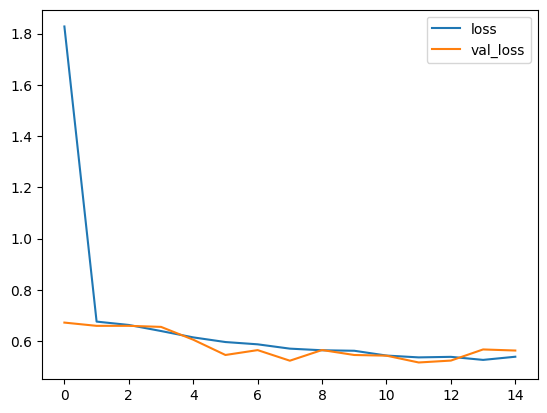

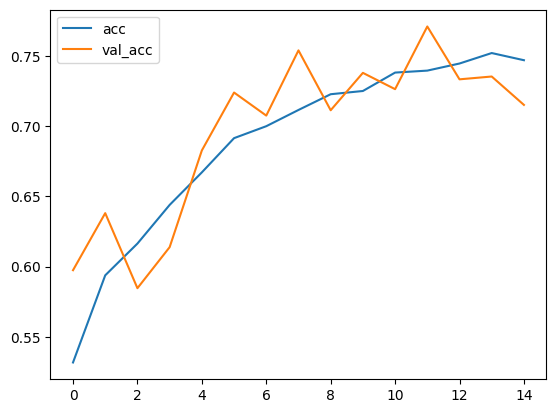

In [14]:


history_df = pd.DataFrame(history.history) 
history_df.loc[:, ['loss', 'val_loss']].plot() 
history_df.loc[:, ['acc', 'val_acc']].plot() 
plt.show() 

### Save the model to be used later for pipelining

In [156]:
from keras.models import load_model

model.save('saved_model.h5')
model.compile(optimizer=RMSprop(learning_rate=0.001),run_eagerly=True, loss='binary_crossentropy', metrics=['acc'])



In [172]:
data_dir = 'dataset/split_output/'

test_dir = data_dir + 'val/'
test_cat_samples_dir = test_dir + 'cats/'
test_dog_samples_dir = test_dir + 'dogs/'


def make_csv_with_test_image_labels(CATS_PATH, DOGS_PATH):
    '''
    Function for making a dataframe that contains images path as well as their labels.
    Parameters:-
     - CATS_PATH - Path for Cats  Images
     - DOGS_PATH - Path for Dogs Images
    Output:-
    It simply returns dataframe
    '''
    cat_images = Path(CATS_PATH).glob('*.jpg')
    dog_images = Path(DOGS_PATH).glob('*.jpg')

    df = []
    for i in cat_images:
        df.append((i, 0))
    for j in dog_images:
        df.append((j, 1))

    df = pd.DataFrame(df, columns=["image_path", "label"], index = None)
    df = df.sample(frac = 1).reset_index(drop=True)

    return df

test_csv = make_csv_with_test_image_labels(test_cat_samples_dir,test_dog_samples_dir)
test_csv.tail()

,image_path,label
4995,dataset/split_output/val/cats/cat.3526.jpg,0
4996,dataset/split_output/val/cats/cat.11058.jpg,0
4997,dataset/split_output/val/cats/cat.11182.jpg,0
4998,dataset/split_output/val/dogs/dog.1055.jpg,1
4999,dataset/split_output/val/cats/cat.7422.jpg,0


In [174]:
test_csv.to_csv('test_labels.csv',sep=",",index=False,encoding='utf-8')

1/1 [==============================] - 0s 83ms/step


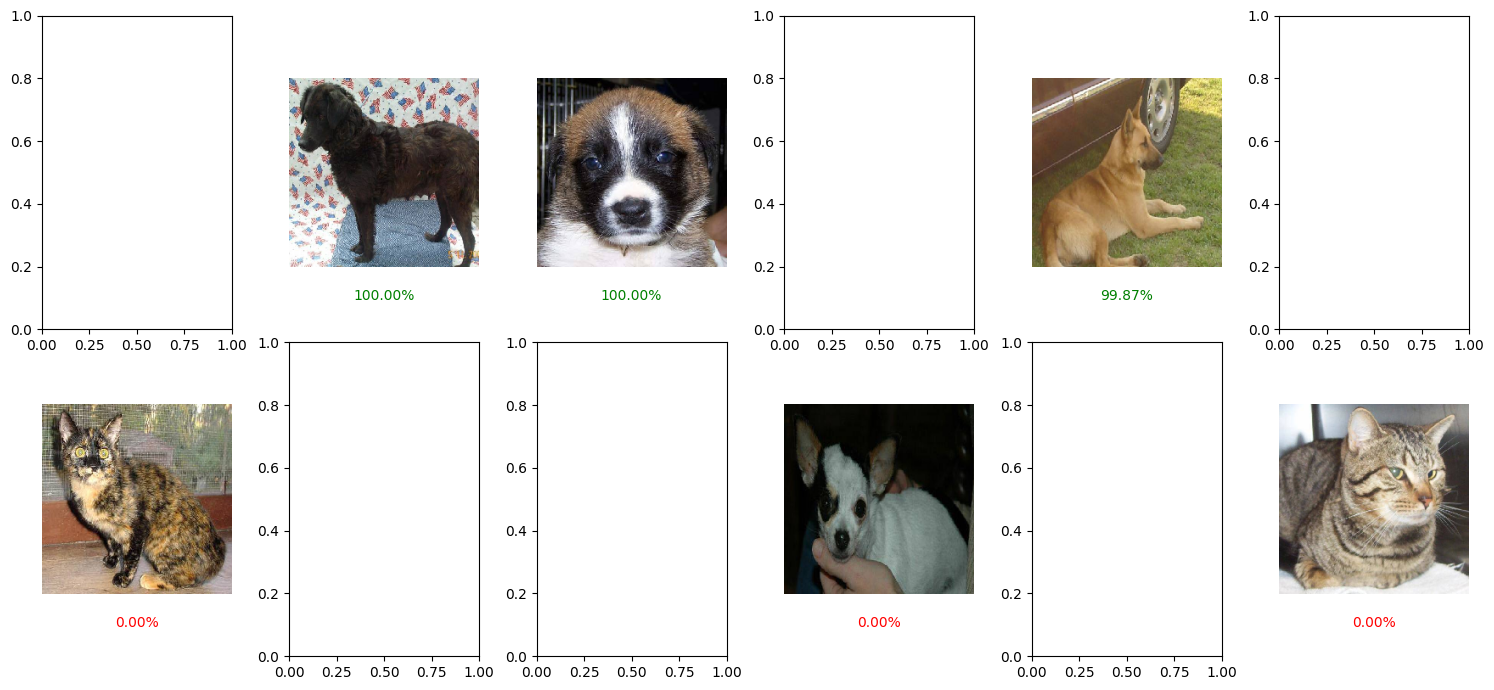

Correctly labeled: 3 images
Incorrectly labeled: 3 images


In [177]:
import random
df=pd.read_csv('./correct_incorrect_labels.csv')

# Function to make predictions and visualize results
def visualize_predictions(model, df, num_samples=6):
    fig, axes = plt.subplots(2, 6, figsize=(15, 7))
    
    correct_count = 0
    incorrect_count = 0
    
    for i in range(num_samples):
        # Choose a random row from the DataFrame
        index = random.randint(0, len(df) - 1)
        img_path = df.loc[index, 'image_path']
        true_label = df.loc[index, 'label']
        
        # Load and preprocess the image
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0
        
        # Make a prediction using the model
        predictions = model.predict(img_array)
        predicted_label = 1 if predictions[0][0] > 0.5 else 0
        
        # Check if the prediction is correct
        is_correct = true_label == predicted_label
        
        # Plot the image with the label
        ax = axes[0, i] if is_correct else axes[1, i]
        ax.imshow(img)
        ax.axis('off')
        
        # Set label color based on correctness
        label_color = 'green' if is_correct else 'red'
        
        # Display label percentage
        ax.text(0.5, -0.15, f'{predictions[0][0]*100:.2f}%', color=label_color, transform=ax.transAxes,
                horizontalalignment='center', verticalalignment='center', fontsize=10)
        
        # Update correct and incorrect count
        if is_correct:
            correct_count += 1
        else:
            incorrect_count += 1
    
    plt.tight_layout()
    plt.show()
    
    print(f'Correctly labeled: {correct_count} images')
    print(f'Incorrectly labeled: {incorrect_count} images')

# Assuming your model variable holds the loaded model
visualize_predictions(model, df)

In [180]:
df

,image_path,label
0,dataset/split_output/val/dogs/dog.7513.jpg,1
1,dataset/split_output/val/dogs/dog.10830.jpg,1
2,dataset/split_output/val/dogs/dog.5469.jpg,1
3,dataset/split_output/val/dogs/dog.1899.jpg,1
4,dataset/split_output/val/dogs/dog.5355.jpg,1
5,dataset/split_output/val/dogs/dog.5021.jpg,1
6,dataset/split_output/val/dogs/dog.5929.jpg,1
7,dataset/split_output/val/cats/cat.11041.jpg,0
8,dataset/split_output/val/cats/cat.3045.jpg,0
9,dataset/split_output/val/cats/cat.9673.jpg,0


1/1 [==============================] - 2s 2s/step
The predicted class is cat with probability 0.00


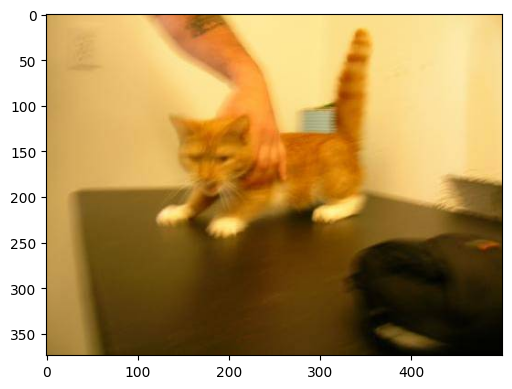

In [160]:

import numpy as np
from tensorflow.keras.preprocessing import image
# import pickle
import matplotlib.pyplot as plt
from keras.models import load_model
import cv2



# Load an image and convert it to a numpy array
img_path = './cat.0.jpg'
test_img=cv2.imread(img_path)
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize pixel values to be between 0 and 1

# Make a prediction using the model
predictions = model.predict(img_array)
probability = predictions[0][0]

# Print the predicted class and probability
if probability > 0.5:
    predicted_class = 'dog'
    plt.figure(figsize=(6,4))
    plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
    plt.tight_layout()
    img = cv2.resize(test_img, (224, 224))
   
else:
    predicted_class = 'cat'
    plt.figure(figsize=(6,4))
    plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
    plt.tight_layout()
    img = cv2.resize(test_img, (224, 224))

print(f'The predicted class is {predicted_class} with probability {probability:.2f}')


1/1 [==============================] - 0s 67ms/step


This image -> Dog
1.0


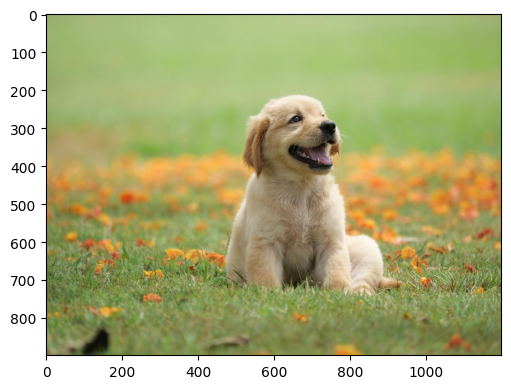

In [161]:


import cv2
import matplotlib.pyplot as plt

def predict_func(img): 
    plt.figure(figsize=(6,4))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.tight_layout()
    img = cv2.resize(img, (224, 224))
    img = np.reshape(img, [-1, 224, 224,3])
    result = np.argmax(model.predict(img_array))
    if confidence_score == 1: 
        print("\033[94m"+"This image -> Dog"+"\033[0m")
        print(confidence_score)
    else: 
        print("\033[94m"+"This image -> Cat"+"\033[0m")
        print(confidence_score)
test_img = cv2.imread("./pupppy.jpg")
predict_func(test_img)